<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Cancer Detection

## Objective
* To build a dense prediction model
* To begin reading current papers in DNN research
___

Implement your network topology

Use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf) 

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)

You should use existing pytorch functions (not your own Conv2D module), such as ```nn.Conv2d``` and ```nn.CrossEntropyLoss```;
you will also need the pytorch function ```torch.cat``` and ```nn.ConvTranspose2d```

```torch.cat``` allows you to concatenate tensors.
```nn.ConvTranspose2d``` is the opposite of ```nn.Conv2d```.
It is used to bring an image from low res to higher res.
[This blog](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) should help you understand this function in detail.



In [31]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm
!pip install tensorflow-addons
import numpy as np
import tensorflow as tf
import cv2
import os
from PIL import Image
import keras
from tqdm import tqdm
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

os.environ['KERAS_BACKEND'] = 'tensorflow'
np.random.seed(1000)

     |████████████████████████████████| 706kB 5.5MB/s 
Found GPU at: /device:GPU:0


In [37]:
from google.colab import drive
drive.mount('/content/drive')
image_directory = '/content/drive/MyDrive/CS-474-Deep-Learning/Tensorflow/cell_images/cell_images/'
size = 64
# Create Empty Data list
dataset = []
label = []
positive_root = image_directory + 'Parasitized/'
parasite_positive = os.listdir(positive_root)
# Infected
loop = tqdm(total = np.ceil(len(parasite_positive)), position = 0, leave = False)
for i, image_name in enumerate(parasite_positive):
  if (image_name.split('.')[1] == 'png'):
    img = cv2.imread(positive_root + image_name)
    img = Image.fromarray(img, 'RGB')
    img = img.resize((size,size))
    dataset.append(np.array(img))
    label.append(0)
  loop.update(1)
loop.close()

# Uninfected
negative_root = image_directory + 'Uninfected/'
parasite_negative = os.listdir(negative_root)
loop = tqdm(total = np.ceil(len(parasite_negative)), position = 0, leave = False)
for i, image_name in enumerate(parasite_negative):
  if (image_name.split('.')[1] == 'png'):
    img = cv2.imread(negative_root + image_name)
    img = Image.fromarray(img, 'RGB')
    img = img.resize((size,size))
    dataset.append(np.array(img))
    label.append(1)
  loop.update(1)
loop.close()


 12%|█▏        | 35/296.0 [00:00<00:00, 347.95it/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


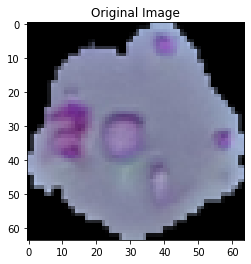

297

In [41]:
import matplotlib.pyplot as plt
def test_plot(int):
  #Display Original Image
  plt.figure()
  plt.title('Original Image')
  plt.imshow(Image.fromarray(dataset[int], 'RGB'))
  plt.show()
test_plot(np.random.randint(0, len(dataset)))
len(dataset)

WARNING: You may run into an error that says "RuntimeError: CUDA out of memory."

In this case, the memory required for your batch is larger than what the GPU is capable of. You can solve this problem by adjusting the image size or the batch size and then restarting the runtime. 

In [42]:
# Input Definition
input_shape = (size, size, 3)
# Model Architecture
input = keras.layers.Input(shape = input_shape)
conv1 = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
norm1 = keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = keras.layers.Dropout(rate=0.2)(norm1)
conv2 = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = keras.layers.Dropout(rate=0.2)(norm2)
flat1 = keras.layers.Flatten()(drop2)  #Flatten the matrix to get it ready for dense.
hidden1 = keras.layers.Dense(512, activation='relu')(flat1)
norm3 = keras.layers.BatchNormalization(axis = -1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.2)(norm3)
hidden2 = keras.layers.Dense(256, activation='relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis = -1)(hidden2)
drop4 = keras.layers.Dropout(rate=0.2)(norm4)
out = keras.layers.Dense(2, activation='sigmoid')(drop4)   #units=1 gives error
# Model Summary
model = keras.Model(inputs=input, outputs=out)
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0   

In [43]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow_addons as tfa

# initialize tqdm callback with default parameters
tqdm_callback = tfa.callbacks.TQDMProgressBar()
X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.20, random_state = 0)
history = model.fit(np.array(X_train), 
                         y_train, 
                         batch_size = 64, 
                         verbose = 1, 
                         epochs = 5,      #Changed to 3 from 50 for testing purposes.
                         validation_split = 0.1,
                         shuffle = False,
                        callbacks=tqdm_callback
                     )


Epoch 1/5
Epoch 1/5


4/4 [==============================] - 18s 124ms/step - loss: 1.8702 - accuracy: 0.5754 - val_loss: 534.5671 - val_accuracy: 0.0417

Epoch 2/5
Epoch 2/5


4/4 [==============================] - 0s 20ms/step - loss: 1.0627 - accuracy: 0.5905 - val_loss: 85.3620 - val_accuracy: 0.0417

Epoch 3/5
Epoch 3/5


4/4 [==============================] - 0s 23ms/step - loss: 0.5295 - accuracy: 0.7912 - val_loss: 3.5601 - val_accuracy: 0.9583

Epoch 4/5
Epoch 4/5


4/4 [==============================] - 0s 21ms/step - loss: 0.3547 - accuracy: 0.8860 - val_loss: 394.9207 - val_accuracy: 0.0000e+00

Epoch 5/5
Epoch 5/5


4/4 [==============================] - 0s 26ms/step - loss: 0.2226 - accuracy: 0.9655 - val_loss: 68.4805 - val_accuracy: 0.0417




2/2 [==============================] - 0s 24ms/step - loss: 63.4749 - accuracy: 0.0833
Test_Accuracy: 8.33%


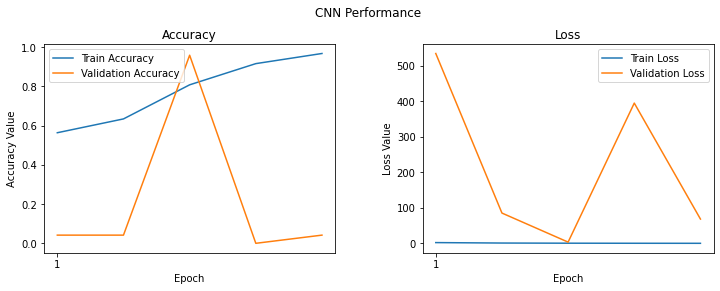

In [44]:
print("Test_Accuracy: {:.2f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
#Save the model
model.save('malaria_cnn.h5')